In [ ]:
import tensorflow as tf
 
device_name = tf.test.gpu_device_name()
 
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
 
print(f"Found GPU at: {device_name}")

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive/') 
%cd '/content/MyDrive/My Drive/Brain_cancer/'

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).
/content/MyDrive/My Drive/Brain_cancer


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from model.lenet import LeNet
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

In [ ]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 25

In [ ]:
print("[INFO] loading images...")
data = []
labels = []

[INFO] loading images...


In [ ]:
imagePaths = sorted(list(paths.list_images("Data")))  #accessing images
len(imagePaths)

2759

In [ ]:
random.seed(42)
random.shuffle(imagePaths)

In [ ]:
# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (28, 28))
	image = img_to_array(image)
	data.append(image)

	# extract the class label from the image path and update the
	# labels list
	label = imagePath.split(os.path.sep)[-2]
	label = 1 if label == "yes" else 0
	labels.append(label)

In [ ]:
len(data)==len(labels)


True

In [ ]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [ ]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

In [ ]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [ ]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=3, classes=2)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	  metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
# train the network
print("[INFO] training network...")
H = model.fit(x=aug.flow(trainX, trainY, batch_size=25),
	validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

In [ ]:
print("[INFO] serializing network...")
model.save("Brain_cancer_new.model", save_format="h5")

[INFO] serializing network...


In [ ]:
accuracy = model.evaluate(testX, testY, verbose=0)    #accuracy
accuracy[1]

0.9767156839370728

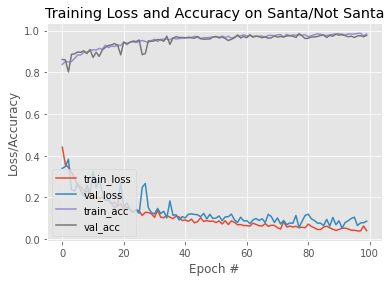

In [ ]:
plt.style.use("ggplot")
plt.figure()
N = 100
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Santa/Not Santa")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot_new.png")

**Testing**

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import numpy as np
import argparse
import imutils
import cv2

In [ ]:
def image_classifier(filename):
  image = cv2.imread(filename)
  orig = image.copy()
  image = cv2.resize(image, (28, 28))
  image = image.astype("float") / 255.0
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)
  #print("[INFO] loading network...")
  model = load_model("Brain_cancer_new.model")
  (no, yes) = model.predict(image)[0]
  # build the label
  label = "Brain cancer detected" if yes > no else "No Brain cancer"
  proba = yes if yes > no else no
  label = "{}".format(label)
  print(label)
  # draw the label on the image
  output = imutils.resize(orig, width=400)
  cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
	0.7, (0, 0, 255), 2)
  cv2_imshow(output)

No Brain cancer


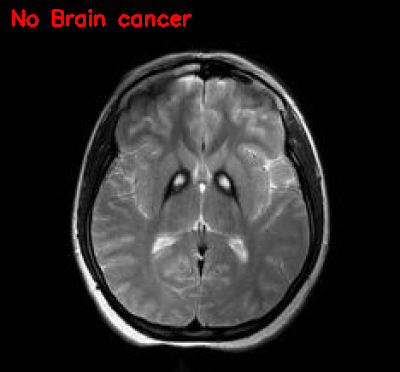

In [ ]:
test_image='/content/MyDrive/My Drive/Brain_cancer/test_image/'
image_classifier('test_image/n3.jpg')